In [ ]:
# !pip install eli5
# !pip install category_encoders
# !pip install lightgbm
# !pip install optuna
# %pip install pytorch-ignite
# !pip install igraph

# Load Libraries

In [40]:
import optuna
from optuna import create_study
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, classification_report, roc_auc_score
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pandas as pd
import numpy as np
from imblearn.under_sampling import *
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.tree import DecisionTreeClassifier

# Helper Functions

In [2]:
# Helper Functions
def get_metrics_pd(y_pred, y_true, model_name):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    accuracy_class_0 = TN / (TN + FP)  # Accuracy for class 0 (non-fraud)
    accuracy_class_1 = TP / (TP + FN)  # Accuracy for class 1 (fraud)
    average_class_accuracy = (accuracy_class_0 + accuracy_class_1) / 2
    auc = roc_auc_score(y_true, y_pred)
    output = pd.DataFrame([(model_name, recall, precision, f1, accuracy, auc)],
                          columns = ["Model", "Recall", "Precision", "F1 Score", "Accuracy", "AUC"])
    return output

# Reading in Original Data (For Preprocessing)

- Please take note if you are running the script. Run the script from top to bottom without going back to the top.
- Even though we have assigned random_states, re-running the script on another machine would still produce a slightly different result.

In [3]:
#Please convert the WDIR to your own WDIR that has the fraudTrain.csv and fraudTest.csv files
WDIR = "C:/Users/regan/Documents/NUS/NUS Modules/Year 3 Semester 1/BT4012/Project"
credit_card_dir_name = "Credit Card Transactions Fraud Detection Dataset"

train = pd.read_csv(f"{WDIR}/{credit_card_dir_name}/fraudTrain.csv")
test = pd.read_csv(f"{WDIR}/{credit_card_dir_name}/fraudTest.csv")

# Data Preprocessing + Resampling

## Data Cleaning

In [4]:
# Data Cleaning
#CONVERT DOB to DATETIME FORMAT
test.dob = pd.to_datetime(test.dob, format = "%Y-%m-%d")
test.trans_date_trans_time = pd.to_datetime(test.trans_date_trans_time, format = "%Y-%m-%d %H:%M:%S")
train.dob = pd.to_datetime(train.dob, format = "%Y-%m-%d")
train.trans_date_trans_time = pd.to_datetime(train.trans_date_trans_time, format = "%Y-%m-%d %H:%M:%S")

#IMPLEMENTATION OF CREATING "AGE" FEATURE
df_diff = test['trans_date_trans_time'] - test['dob']
test['age'] = df_diff.apply(lambda x: round(x.days/365,0))
#df_test.drop('date_create', axis = 1)
#EXTRACT PARTS OF DATETIME OBJECT
test['trans_month'] = test['trans_date_trans_time'].dt.month
test['trans_day'] = test['trans_date_trans_time'].dt.day_of_week
test['trans_hour'] = test['trans_date_trans_time'].dt.hour

df_diff = train['trans_date_trans_time'] - train['dob']
train['age'] = df_diff.apply(lambda x: round(x.days/365,0))
train['trans_month'] = train['trans_date_trans_time'].dt.month
train['trans_day'] = train['trans_date_trans_time'].dt.day_of_week
train['trans_hour'] = train['trans_date_trans_time'].dt.hour

df_train = train.loc[train['age'] >= 18].reset_index(drop=True)
df_test = test.loc[test['age'] >= 18].reset_index(drop= True)

#BINNING OF AGE
def age_bin(x):
    if x <30:
        return 'youth'
    elif 30 <= x < 60:
        return 'middle'
    else:
        return 'old'
df_train['age_bin'] = df_train['age'].apply(lambda x: age_bin(int(x)))
df_test['age_bin'] = df_test['age'].apply(lambda x: age_bin(int(x)))

## Categorical Variable Encoding

In [5]:
#Preprocess - Scaling/Encoding

#FREQUENCY COUNT ENCONDER
encoder = ce.CountEncoder(cols="state", normalize=True)
df_train["state_fe"] = encoder.fit_transform(df_train["state"])
df_test["state_fe"] = encoder.transform(df_test["state"])

encoder = ce.CountEncoder(cols="category", normalize=True)
df_train["category_fe"] = encoder.fit_transform(df_train["category"])
df_test["category_fe"] = encoder.transform(df_test["category"])

encoder = ce.CountEncoder(cols="job", normalize=True)
df_train["job_fe"] = encoder.fit_transform(df_train["job"])
df_test["job_fe"] = encoder.transform(df_test["job"])

#ONE HOT ENCODER
enc = OneHotEncoder()
gender_enc = pd.DataFrame(enc.fit_transform(df_train[['gender']]).toarray())
gender_enc.columns = [col for cols in enc.categories_ for col in cols]
df_train = pd.concat([df_train, gender_enc], axis = 1)

gender_enc = pd.DataFrame(enc.transform(df_test[['gender']]).toarray())
gender_enc.columns = [col for cols in enc.categories_ for col in cols]
df_test = pd.concat([df_test, gender_enc],axis = 1 )

#ORDINAL ENCODER
enc = OrdinalEncoder(categories=[['youth', 'middle', 'old']])
df_train['age_en'] = enc.fit_transform(df_train["age_bin"].values.reshape(-1,1))
df_test['age_en'] = enc.transform(df_test['age_bin'].values.reshape(-1,1))


## Data Scaling

In [6]:
#IMPLEMENTATION OF SIN / COS TRANSFORMATION TO CAPTURE SEASONALITY/TREND
def sin_transformation(x, p):
    return np.sin(x / p * 2 * np.pi)
def cos_transformation(x, p):
    return np.cos(x/ p * 2 * np.pi)

#month
df_train['trans_month_sin'] = df_train.trans_month.apply(lambda x: sin_transformation(x, 12))
df_train['trans_month_cos'] = df_train.trans_month.apply(lambda x: cos_transformation(x, 12))
df_test['trans_month_sin'] = df_test.trans_month.apply(lambda x: sin_transformation(x, 12))
df_test['trans_month_cos'] = df_test.trans_month.apply(lambda x: cos_transformation(x, 12))

#day
df_train['trans_day_sin'] = df_train.trans_day.apply(lambda x: sin_transformation(x, 7))
df_train['trans_day_cos'] = df_train.trans_day.apply(lambda x: cos_transformation(x, 7))
df_test['trans_day_sin'] = df_test.trans_day.apply(lambda x: sin_transformation(x, 7))
df_test['trans_day_cos'] = df_test.trans_day.apply(lambda x: cos_transformation(x, 7))

#hour
df_train['trans_hour_sin'] = df_train.trans_hour.apply(lambda x: sin_transformation(x, 24))
df_train['trans_hour_cos'] = df_train.trans_hour.apply(lambda x: cos_transformation(x, 24))
df_test['trans_hour_sin'] = df_test.trans_hour.apply(lambda x: sin_transformation(x, 24))
df_test['trans_hour_cos'] = df_test.trans_hour.apply(lambda x: cos_transformation(x, 24))

# Logarithmic Scaling of amt
df_train['log_amt'] = np.log(df_train['amt'])
df_test['log_amt'] = np.log(df_test['amt'])

from sklearn.preprocessing import StandardScaler, RobustScaler
ss = StandardScaler()
df6= df_train['log_amt'].values.reshape(-1,1)
df7 = pd.DataFrame(ss.fit_transform(df6))
df7.columns = ['scale_log_amt']
df_train = pd.concat([df_train, df7], axis=1)

df8 = df_test['log_amt'].values.reshape(-1,1)
df9 = pd.DataFrame(ss.transform(df8))
df9.columns = ['scale_log_amt']
df_test = pd.concat([df_test, df9], axis = 1)

df_test.to_csv("TEST_FULL", index = False)

final_cols = ['is_fraud',
              'trans_day_sin', 'trans_day_cos', 'trans_hour_sin', 'trans_hour_cos', 'trans_month_sin', 'trans_month_cos',
              'state_fe', 'category_fe', 'job_fe',
              'M', 'F',
              'age_en',
              'scale_log_amt']

train_final = df_train[final_cols]
test_final = df_test[final_cols]

train_final.to_csv("TRAIN_FINAL", index = False)
test_final.to_csv("TEST_FINAL", index = False)

X_train = train_final.drop(["is_fraud"], axis = 1)
X_test = test_final.drop(["is_fraud"], axis = 1)
y_train = train_final["is_fraud"]
y_test = test_final["is_fraud"]

## Resampling

In [7]:
resampl=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=88)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train,stratify=y_train,test_size=0.4, random_state=88)
X_train_, y_train_ = resampl.fit_resample(Xtrain, ytrain)

VAL = Xval
VAL['is_fraud'] = yval
VAL.to_csv('VALIDATION',index = False)

TRAIN = X_train_
TRAIN['is_fraud'] = y_train_
TRAIN.to_csv('TRAINING', index = False)

TEST = test_final
TEST.to_csv("TEST", index = False)



# Reading in Resampled Data (or adjust to reading var from resample)

# Logistic Regression

Optuna Hyperparameter Optimisation

In [91]:
from optuna.samplers import TPESampler
test = pd.read_csv('TEST')
train = pd.read_csv('TRAINING')
validation = pd.read_csv('VALIDATION')

Xf_train = train.drop(["is_fraud"], axis = 1)#[final_features]
Xf_test = test.drop(["is_fraud"], axis = 1)#[final_features]
Xf_valid = validation.drop(["is_fraud"], axis = 1)#[final_features]
yf_train = train["is_fraud"]
yf_test = test["is_fraud"]
yf_valid = validation["is_fraud"]
def instantiate_lr(t):
  param_dict = {
    'solver': t.suggest_categorical('solver',['sag']), #'liblinear', 'lbfgs', 'saga']),
    'penalty': t.suggest_categorical('penalty',['l2']),
    'C': t.suggest_loguniform('C',85.98737339212276,85.98737339212276),
    'random_state': 88,
    'class_weight': 'balanced',
    'n_jobs': -1
  }
  return LogisticRegression(**param_dict)

def objective(trail, X, y, X_val, y_val):
  model = instantiate_lr(trail)
  #X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, stratify = y_train, random_state = 88 )
  #cv = RepeatedStratifiedKFold(n_splits = 5, random_state= 88, n_repeats= 1)
  #for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
  #  X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
  #  X_val, y_val = X.iloc[test_idx], y.iloc[test_idx]
  model.fit(X, y)
  if trail.should_prune():
    raise optuna.TrialPruned()
  y_pred_val = model.predict(X_val)
  f1 = f1_score(y_val, y_pred_val)
  return f1

# study = create_study(direction='maximize',
#                      pruner=SuccessiveHalvingPruner(),
#                     sampler=TPESampler(seed=88))
# study.optimize(lambda trial: objective(trial, Xf_train, yf_train, Xf_valid, yf_valid), n_trials=1) # Originally using 100 but as we found the best hyperparameter, it is now 1.
# best_params_LR = study.best_params


Evaluation (Logistic Regression)

In [92]:
best_param = {'solver': 'sag', 'penalty': 'l2', 'C': 85.98737339212276} #After Optuna

LR_best = LogisticRegression(**best_param)

#Feature Importance Tuning
def val_model_get_importance_LG(X_val_,y_val_):
    LR_best.fit(X_val_,y_val_)
    return LR_best.coef_[0]

current_features = Xf_valid.columns.tolist()
performance_history = []
remove_features = []

###Extract Useful Features
for i in range(len(current_features)):
    importances = val_model_get_importance_LG(Xf_valid[current_features], yf_valid)

    val_performance = f1_score(yf_valid,LR_best.predict(Xf_valid[current_features]))
    print(val_performance)
    performance_history.append(val_performance)

    least_important = current_features[np.argmin(importances)]
    remove_features.append(least_important)
    current_features.remove(least_important)

    if val_performance < 0.5:
        break

### Remove Redundant Features
features_to_remove = remove_features[:np.argmax(performance_history)]

#Instantiate train/test/valid + remove redundant features
Xf_train = train.drop(["is_fraud"], axis = 1)
Xf_test = test.drop(["is_fraud"], axis = 1)
Xf_valid = validation.drop(["is_fraud"], axis = 1)

#Train (Train + Val)
Xf_train = pd.concat([Xf_train,Xf_valid]).drop(features_to_remove,axis = 1)
yf_train = pd.concat([yf_train,yf_valid])

#Test
Xf_test = Xf_test.drop(features_to_remove,axis=1)

#Fit LG Model w/ best params
LR_best.fit(Xf_train, yf_train)


# Train Metrics
lr_train_metrics = get_metrics_pd(LR_best.predict(Xf_train), yf_train, "Logistic Regression [Train]")

# Test Metrics
lr_test_metrics = get_metrics_pd(LR_best.predict(Xf_test), yf_test, "Logistic Regression [Test]")

output_df = pd.concat([lr_train_metrics, lr_test_metrics], axis = 0)
output_df

c:\Users\regan\Documents\NUS\NUS Modules\Year 3 Semester 1\BT4012\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.015252621544327933


,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,Logistic Regression [Train],0.73018,0.793384,0.760471,0.827079,0.807815
0,Logistic Regression [Test],0.71049,0.029441,0.056540,0.907503,0.809382


Feature Importance

            feature  importance
3    trans_hour_cos    1.772454
12    scale_log_amt    1.207116
4   trans_month_sin    0.244560
5   trans_month_cos    0.071868
2    trans_hour_sin    0.049792
11           age_en    0.031877
0     trans_day_sin    0.001268
6          state_fe   -0.104068
1     trans_day_cos   -0.205594
9                 M   -0.460868
10                F   -0.490060
7       category_fe   -1.597712
8            job_fe -180.074517


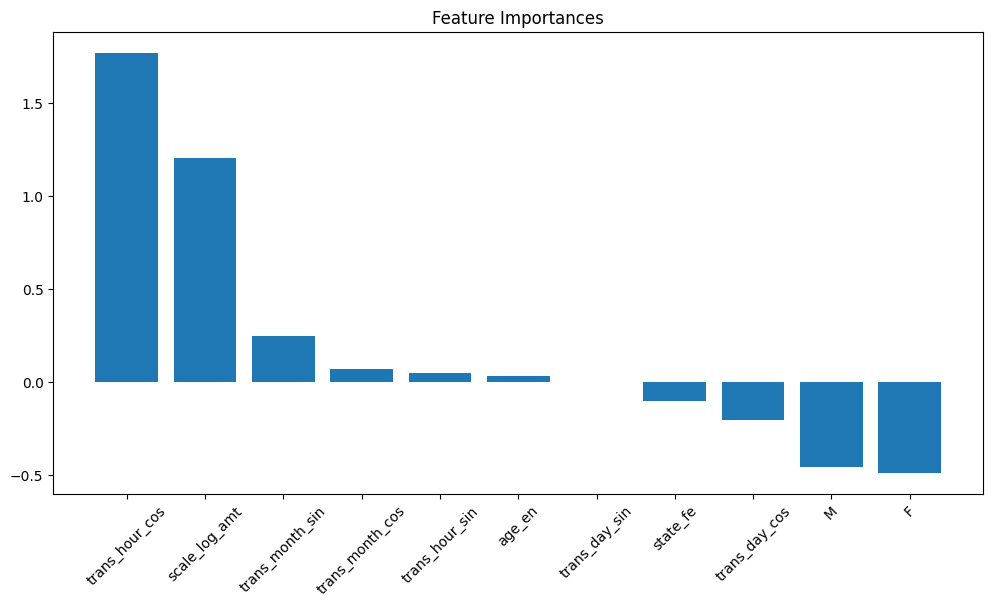

In [107]:
#Retrieve feature importances through coefficients
importances_lr = LR_best.coef_

#Convert to a Dataframe
feature_importances_lr = pd.DataFrame({'feature': Xf_train.columns.values, 'importance': importances_lr[0]})

#Sort by importances
feature_importances_lr = feature_importances_lr.sort_values('importance', ascending = False)

#Display
print(feature_importances_lr)

#Plot
plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(feature_importances_lr['feature'][:11],feature_importances_lr['importance'][:11]) # Filtered job_fe for better visualization
plt.xticks(rotation=45)
plt.show()


Confusion Metrics (Logistirc Regression)

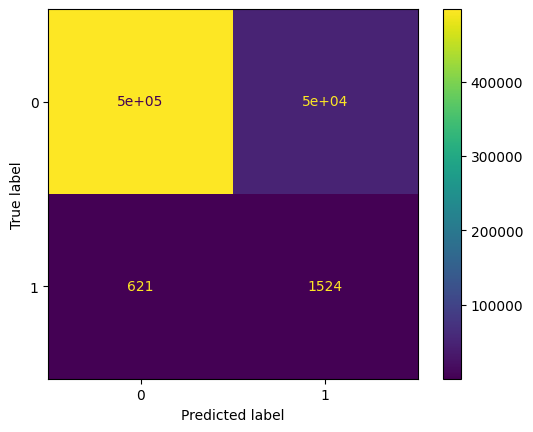

In [43]:
y_pred_test = LR_best.predict(Xf_test)
cm = confusion_matrix(yf_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

AUC_ROC (Logistic Regression)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


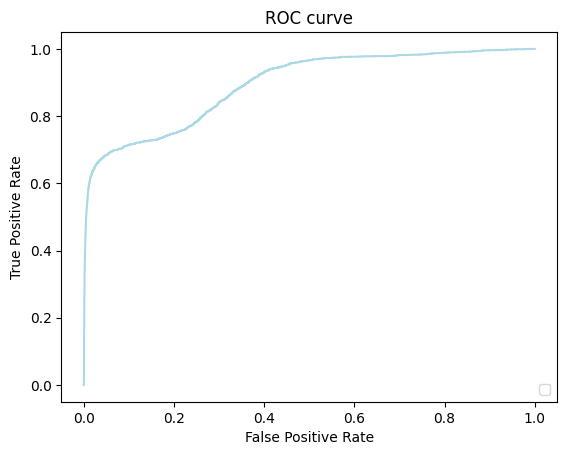

In [44]:
y_proba = LR_best.predict_proba(Xf_test)
def plot_auc_roc_curve(yf_test, y_pred):
    fpr, tpr,_ = roc_curve(yf_test, y_pred)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'lightblue')
    #plt.plot([0, 1], [0, 1], color = 'lightblue')
    plt.title('ROC curve')
plot_auc_roc_curve(yf_test, y_proba[:, 1])

# Neural Network



In [75]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt


train = pd.read_csv("TRAINING")
valid = pd.read_csv("VALIDATION")
test = pd.read_csv("TEST")

X_train, y_train = train.drop("is_fraud", axis = 1), train['is_fraud']
X_valid, y_valid = valid.drop("is_fraud", axis = 1), valid['is_fraud']
X_test, y_test = test.drop("is_fraud", axis = 1), test['is_fraud']

# define the objective function for optuna
def objective(trial, X_train, y_train, X_valid, y_valid):
    ll_scores = []

    # define the hyperparameters to be tuned
    hidden_layer_sizes = tuple([trial.suggest_int(f'layer_{i}', 50, 150) for i in range(trial.suggest_int('n_layers', 3,4))])
    activation = trial.suggest_categorical('activation', ['relu'])
    solver = trial.suggest_categorical('solver', ['adam'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    learning_rate = trial.suggest_categorical('learning_rate', ['adaptive'])
    max_iter =  30 #smaller epochs to conduct more trials faster

    # create the neural network classifier with the hyperparameters
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=max_iter, random_state=88)

    # train the classifier on the training set
    clf.fit(X_train, y_train)

    # evaluate the classifier on the testing set
    y_pred = clf.predict(X_valid)
    ll_ = log_loss(y_valid, y_pred)
    ll_scores.append(ll_)

    return ll_

# # create the optuna study and optimize the hyperparameters
# pruner = SuccessiveHalvingPruner(reduction_factor=2)
# study = optuna.create_study(direction='minimize', pruner = pruner, sampler = TPESampler(seed = 88))
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials = 25)
# best_params = study.best_params


# # print the best hyperparameters and the corresponding score
# print('Best hyperparameters:', study.best_params)
# print('Best score:', study.best_value)

Fitting the model after training

In [76]:
train = pd.read_csv("TRAINING")
valid = pd.read_csv("VALIDATION")
test = pd.read_csv("TEST")

X_train, y_train = train.drop("is_fraud", axis = 1), train['is_fraud']
X_valid, y_valid = valid.drop("is_fraud", axis = 1), valid['is_fraud']
X_test, y_test = test.drop("is_fraud", axis = 1), test['is_fraud']

best_params = {'n_layers': 4, 'layer_0': 140, 'layer_1': 147, 'layer_2': 85, 'layer_3': 121, 'activation': 'relu', 'solver': 'adam', 'alpha': 5.088419907877155e-05, 'learning_rate': 'adaptive'}
clf = MLPClassifier(hidden_layer_sizes=tuple([best_params[f'layer_{i}'] for i in range(best_params['n_layers'])]), activation=best_params['activation'], solver=best_params['solver'], alpha=best_params['alpha'], learning_rate=best_params['learning_rate'], max_iter=100, random_state=88)
X_train_comb = pd.concat([X_train, X_valid])
y_train_comb = pd.concat([y_train, y_valid])
clf.fit(X_train_comb, y_train_comb)

MLPClassifier(alpha=5.088419907877155e-05,
              hidden_layer_sizes=(140, 147, 85, 121), learning_rate='adaptive',
              max_iter=100, random_state=88)

Optimizing Threshold Based on F1 score

In [77]:
#Threshold optimization based on f1 score
def nn_threshold_f1(clf, y, X):
    thresholds = np.arange(0.1, 1.0, 0.1)
    y_hat = clf.predict_proba(X)[:,1]

    def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype(int)

    scores = [f1_score(y, to_labels(y_hat, t)) for t in thresholds]
    ix = np.argmax(scores)
    #print(f"Threshold = {thresholds[ix]}, F-Score = {scores[ix]}")
    return(thresholds[ix])

nn_threshold_f1(clf, y_test, X_test)

0.9

Metrics

In [78]:
def nn_metrics(name, clf, y, X, threshold = 0.5):
    y_true = np.array(y)
    y_pred_proba = clf.predict_proba(X)[:,1]
    y_pred = np.array(y_pred_proba)
    y_pred = (y_pred > threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    TN, FP, FN, TP = conf_matrix.ravel()
    accuracy_class_0 = TN / (TN + FP)  # Accuracy for class 0 (non-fraud)
    accuracy_class_1 = TP / (TP + FN)  # Accuracy for class 1 (fraud)
    average_class_accuracy = (accuracy_class_0 + accuracy_class_1) / 2


    auc_score = roc_auc_score(y_true, np.array(y_pred_proba))

    output = pd.DataFrame([(f"Neural Network {name}", recall, precision, f1, accuracy, average_class_accuracy, auc_score)],
                            columns = ["Model", "Recall", "Precision", "F1 Score", "Accuracy", "Avg Class Accuracy", "AUC"])

    return output

#uncomment for train and validation set metrics
#train_metrics = nn_metrics('train', clf, y_train, X_train, threshold=threshold)
#valid_metrics = nn_metrics('validation', clf, y_valid, X_valid, threshold=threshold)
test_metrics = nn_metrics("test", clf, y_test, X_test, threshold=nn_threshold_f1(clf, y_test, X_test))

metrics = pd.concat([test_metrics], axis=0)
metrics

,Model,Recall,Precision,F1 Score,Accuracy,Avg Class Accuracy,AUC
0,Neural Network test,0.60373,0.579418,0.591324,0.996745,0.801007,0.964103


Confusion Matrix

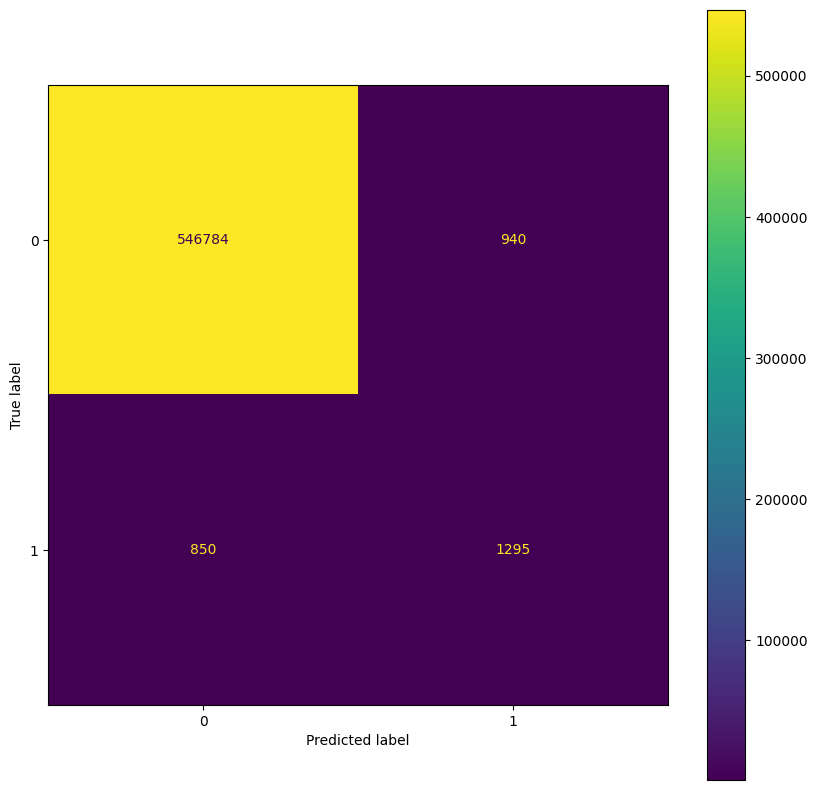

In [79]:
#plotting confusion matrix
def nn_confusion_mat(clf, y, X, threshold = 0.5):
    y_true = np.array(y)
    y_pred_proba = clf.predict_proba(X)[:,1]
    y_pred = np.array(y_pred_proba)
    y_pred = (y_pred > threshold).astype(int)

    conf_matrix = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
    disp.plot(ax=ax)

    plt.show()

nn_confusion_mat(clf, y_test, X_test, threshold=nn_threshold_f1(clf, y_test, X_test))

ROC Curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


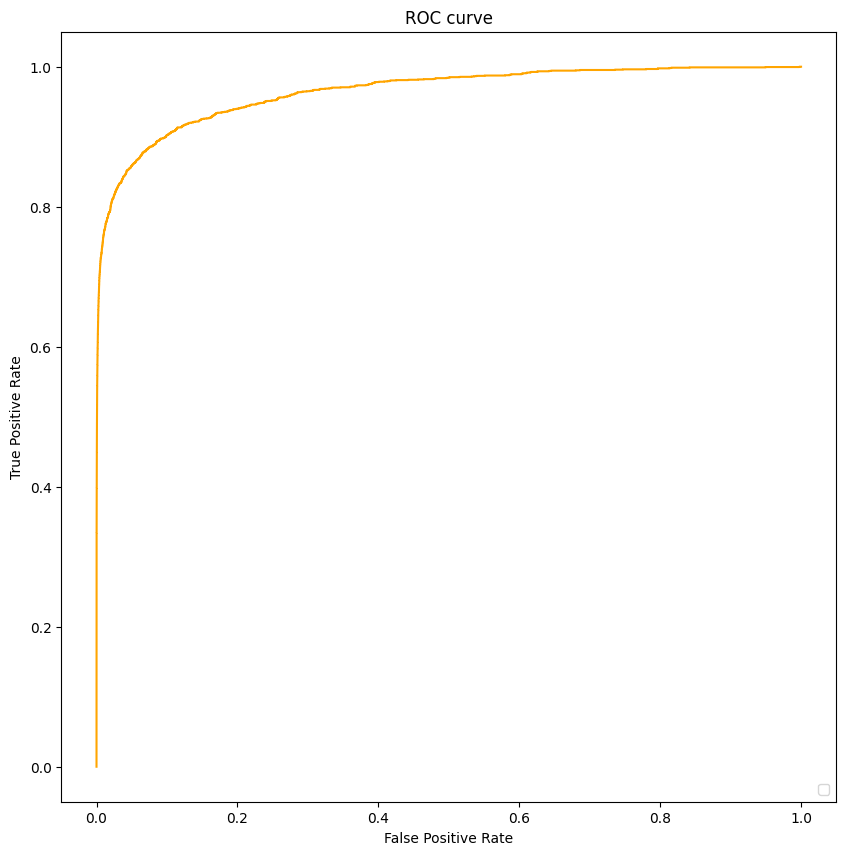

In [80]:
def plot_auc_roc_curve(clf, y, X):
    y_true = np.array(y)
    y_pred_proba = clf.predict_proba(X)[:,1]

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

    fig, ax = plt.subplots(figsize=(10, 10))

    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, color = 'orange')
    plt.title('ROC curve')
    plt.show()

plot_auc_roc_curve(clf, y_test, X_test)

# Random Forest

Optuna Hyperparameter Optimisation

In [18]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, log_loss
import numpy as np
from optuna import create_study
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
import optuna
import seaborn as sns
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt


test = pd.read_csv('TEST')
train = pd.read_csv('TRAINING')
validation = pd.read_csv('VALIDATION')

X_train = train.drop(["is_fraud"], axis = 1)
X_test = test.drop(["is_fraud"], axis = 1)
X_valid = validation.drop(["is_fraud"], axis = 1)
y_train = train["is_fraud"]
y_test = test["is_fraud"]
y_valid = validation["is_fraud"]

def objective(trial, X, y, X_valid, y_valid):
    f1_scores = []
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 90, 500),
        # "n_estimators": 10,
        "max_depth": trial.suggest_int('max_depth', 20, 45),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 32),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": 'sqrt',
        "random_state": 88,
        # 'criterion' : 'log_loss',
        # "class_weight" : "balanced",
        "n_jobs" : -1
    }
    model = RandomForestClassifier(**params)
    model.fit(X,y)
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds)
    return f1

    # Minimize Logloss
    # model = RandomForestClassifier(**params)
    # model.fit(X,y)
    # preds_proba = model.predict_proba(X_valid)[:, 1]
    # logloss = log_loss(y_valid, preds_proba)
    # return logloss

# Optuna Study
# study = create_study(direction='maximize',
#                      pruner=SuccessiveHalvingPruner(),
#                     sampler=TPESampler(seed=88))
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=1)

# best_params = study.best_params

Evaluation (Random Forest)

In [19]:
# Best Parameters are gotten from Optuna study above

best_params = {'n_estimators': 206, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, "random_state": 88}
brf = RandomForestClassifier(**best_params)
# Feature Importance Tuning

test = pd.read_csv('TEST')
train = pd.read_csv('TRAINING')
validation = pd.read_csv('VALIDATION')

X_train = train.drop(["is_fraud"], axis = 1)
X_test = test.drop(["is_fraud"], axis = 1)
X_valid = validation.drop(["is_fraud"], axis = 1)
y_train = train["is_fraud"]
y_test = test["is_fraud"]
y_valid = validation["is_fraud"]

def val_model_get_importance(X_val_, y_val_):
    brf.fit(X_val_, y_val_)
    return brf.feature_importances_

current_features = X_valid.columns.tolist()
performance_history = []
remove_features = []

for i in range(len(current_features)):
    # Train model and get feature importances
    importances = val_model_get_importance(X_valid[current_features], y_valid)

    # Evaluate model performance
    val_performance = f1_score(y_valid, brf.predict(X_valid[current_features]))
    performance_history.append(val_performance)

    # Get the least important feature
    least_important = current_features[np.argmin(importances)]
    remove_features.append(least_important)
    current_features.remove(least_important)

    if val_performance < 0.5:
        break

features_to_remove = remove_features[:np.argmax(performance_history)]

X_train = pd.concat([X_train, X_valid]).drop(features_to_remove, axis = 1)
y_train = pd.concat([y_train, y_valid])

X_test = X_test.drop(features_to_remove, axis = 1)

brf.fit(X_train, y_train)
y_pred_test = brf.predict(X_test)
# Train Metrics
brf_train_metrics = get_metrics_pd(brf.predict(X_train), y_train, "RandomForest [Train]")

# Test Metrics
brf_test_metrics = get_metrics_pd(brf.predict(X_test), y_test, "RandomForest [Test]")

output_df = pd.concat([brf_train_metrics, brf_test_metrics], axis = 0)
output_df

,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,RandomForest [Train],0.999999,0.999996,0.999997,0.999998,0.999998
0,RandomForest [Test],0.704429,0.842252,0.767200,0.998332,0.851956


Feature Importance (Random Forest)

            feature  importance
12    scale_log_amt    0.512654
3    trans_hour_cos    0.216508
2    trans_hour_sin    0.083244
7       category_fe    0.073555
6          state_fe    0.028815
4   trans_month_sin    0.020698
8            job_fe    0.018328
5   trans_month_cos    0.016101
11           age_en    0.009079
1     trans_day_cos    0.008396
0     trans_day_sin    0.007641
9                 M    0.002529
10                F    0.002452


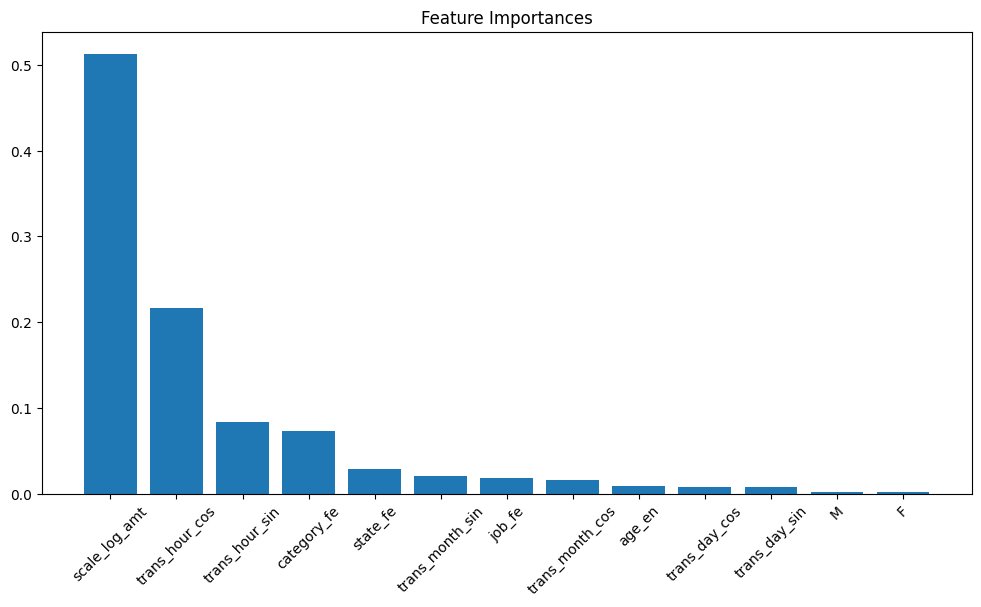

In [45]:
# Retrieve feature importances
importances = brf.feature_importances_

# Convert to a DataFrame
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Display
print(feature_importances)

# Plotting
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45)
plt.show()

roc-auc (Random Forest)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


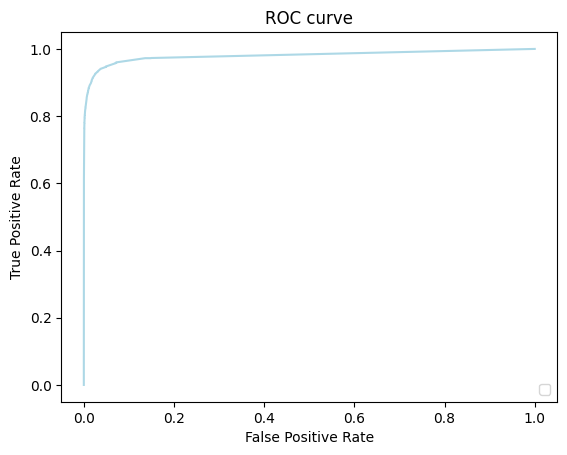

In [46]:
y_proba = brf.predict_proba(X_test)
def plot_auc_roc_curve(yf_test, y_pred):
    fpr, tpr,_ = roc_curve(yf_test, y_pred)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'lightblue')
    #plt.plot([0, 1], [0, 1], color = 'lightblue')
    plt.title('ROC curve')
plot_auc_roc_curve(y_test, y_proba[:, 1])

Confusion Matrix (Random Forest)


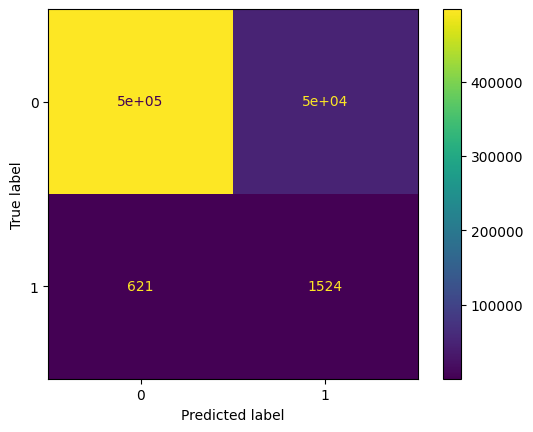

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# XGBoost

Optuna Hyperparameter Optimisation

## Weighted Classes

In [99]:
# Packages
import xgboost
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import numpy as np
from optuna import create_study
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import *
import optuna

train = pd.read_csv('TRAIN_FINAL')
before_X = train.drop(columns = "is_fraud")
before_y = train["is_fraud"]

test = pd.read_csv('TEST_FINAL')
#before_X = X_train
#before_y = y_train
X_train_, X_val_, y_train_, y_val_ = train_test_split(before_X, before_y, test_size=0.4, random_state=88, stratify=before_y)
X_test = test.drop(columns= 'is_fraud')
y_test = test['is_fraud']

positive_count = sum(y_train_ == 1)
negative_count = sum(y_train_ == 0)
scale_pos_weight = negative_count / positive_count

def objective(trial, X, y, X_val, y_val):
    ll_scores = []
    params = {
        "gamma": trial.suggest_float("gamma", 0.1, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0),
        'scale_pos_weight': scale_pos_weight,
        "objective": "binary:logistic",
        "n_estimators": 1000,
        "verbosity": 0,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "num_iterations": trial.suggest_int('num_iterations',5, 200, 5),
        'max_depth' : trial.suggest_int('max_depth',3,10),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,10),
        'random_state': 88,
        'eval_metric': "logloss"
    }
    dtrain = xgboost.DMatrix(X, label = y)
    dval = xgboost.DMatrix(X_val, label= y_val)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")

    model = xgboost.train(
        params,
        dtrain,
        evals=[(dval, 'validation')],
            callbacks=[pruning_callback] )

    preds = model.predict(dval)
    ll_ = log_loss(y_val, preds)
    ll_scores.append(ll_)
    return(ll_)

# study = create_study(direction = 'minimize',
#   pruner=SuccessiveHalvingPruner(reduction_factor=2),
#   sampler=TPESampler(seed=88))
# study.optimize(lambda trial : objective(trial, X_train_, y_train_, X_val_, y_val_), n_trials = 50)
# best_param = study.best_params

best_param = {'gamma': 2.993511795292199,
 'reg_alpha': 0.31976223474810683,
 'reg_lambda': 4.465039850394956,
 'learning_rate': 0.09967868671251486,
 'num_leaves': 252,
 'subsample': 0.6015720352391905,
 'colsample_bytree': 0.71279113532411,
 'min_data_in_leaf': 1,
 'num_iterations': 60,
 'max_depth': 10,
 'min_child_weight': 7}
xgb = xgboost.XGBClassifier(**best_param)

# Feature Importance Tuning
def val_model_get_importance(X_val_, y_val_):
    xgb.fit(X_val_, y_val_)
    return xgb.feature_importances_

current_features = X_val_.columns.tolist()
performance_history = []
remove_features = []

for i in range(len(current_features)):
    # Train model and get feature importances
    importances = val_model_get_importance(X_val_[current_features], y_val_)

    # Evaluate model performance
    val_performance = f1_score(y_val_, xgb.predict(X_val_[current_features]))  # Implement this function based on your needs
    performance_history.append(val_performance)

    # Get the least important feature
    least_important = current_features[np.argmin(importances)]
    remove_features.append(least_important)
    current_features.remove(least_important)

    if val_performance < 0.5:
        break

features_to_remove = remove_features[:np.argmax(performance_history)]

X_train = pd.concat([X_train_, X_val_]).drop(features_to_remove, axis = 1)
y_train = pd.concat([y_train_, y_val_])

X_test = X_test.drop(features_to_remove, axis = 1)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.71279113532411, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.993511795292199,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09967868671251486,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=7, min_data_in_leaf=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_iterations=60, ...)

In [100]:
# Test Metrics
xgb_test_metrics_wll = get_metrics_pd(xgb.predict(X_test), y_test, "XGBoost Weighted Class [Test]")

## Resampled Data Without Regularization

In [101]:
train = pd.read_csv('TRAINING')
val = pd.read_csv('VALIDATION')
test = pd.read_csv('TEST')

X_train_ = train.drop(columns= 'is_fraud')
y_train_ = train['is_fraud']
X_val_ = val.drop(columns= 'is_fraud')
y_val_ = val['is_fraud']
X_test = test.drop(columns= 'is_fraud')
y_test = test['is_fraud']

def objective(trial, X, y, X_val, y_val):
    ll_scores = []
    params = {
        "objective": "binary:logistic",
        "n_estimators": 1000,
        "verbosity": 0,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "num_iterations": trial.suggest_int('num_iterations',5, 200, 5),
        'max_depth' : trial.suggest_int('max_depth',3,10),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,10),
        'random_state': 88,
        'eval_metric': "logloss"
    }
    dtrain = xgboost.DMatrix(X, label = y)
    dval = xgboost.DMatrix(X_val, label= y_val)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")

    model = xgboost.train(
        params,
        dtrain,
        evals=[(dval, 'validation')],
            callbacks=[pruning_callback] )

    preds = model.predict(dval)
    ll_ = log_loss(y_val, preds)
    ll_scores.append(ll_)
    return(ll_)

# study = create_study(direction = 'minimize',
#   pruner=SuccessiveHalvingPruner(reduction_factor=2),
#   sampler=TPESampler(seed=88))
# study.optimize(lambda trial : objective(trial, X_train_, y_train_, X_val_, y_val_), n_trials = 50)
# best_param = study.best_params

best_param = {'learning_rate': 0.09926269858735108,
 'num_leaves': 261,
 'subsample': 0.5209194884761927,
 'colsample_bytree': 0.5634480062878375,
 'min_data_in_leaf': 90,
 'num_iterations': 40,
 'max_depth': 10,
 'min_child_weight': 7}
xgb = xgboost.XGBClassifier(**best_param)

# Feature Importance Tuning
def val_model_get_importance(X_val_, y_val_):
    xgb.fit(X_val_, y_val_)
    return xgb.feature_importances_

current_features = X_val_.columns.tolist()
performance_history = []
remove_features = []

for i in range(len(current_features)):
    # Train model and get feature importances
    importances = val_model_get_importance(X_val_[current_features], y_val_)

    # Evaluate model performance
    val_performance = f1_score(y_val_, xgb.predict(X_val_[current_features]))  # Implement this function based on your needs
    performance_history.append(val_performance)

    # Get the least important feature
    least_important = current_features[np.argmin(importances)]
    remove_features.append(least_important)
    current_features.remove(least_important)

    if val_performance < 0.5:
        break

features_to_remove = remove_features[:np.argmax(performance_history)]

X_train = pd.concat([X_train_, X_val_]).drop(features_to_remove, axis = 1)
y_train = pd.concat([y_train_, y_val_])

X_test = X_test.drop(features_to_remove, axis = 1)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5634480062878375, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09926269858735108,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=7, min_data_in_leaf=90, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_iterations=40, ...)

In [102]:
xgb_train_metrics_no_reg = get_metrics_pd(xgb.predict(X_train), y_train, "XGBoost Resampled Data W/O Regularization [Train]")
xgb_test_metrics_no_reg = get_metrics_pd(xgb.predict(X_test), y_test, "XGBoost Resampled Data W/O Regularization[Test]")

no_reg_res = pd.concat([xgb_train_metrics_no_reg, xgb_test_metrics_no_reg], axis = 0)
no_reg_res

,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,XGBoost Resampled Data W/O Regularization [Train],0.996073,0.997872,0.996972,0.997725,0.997397
0,XGBoost Resampled Data W/O Regularization[Test],0.761305,0.755669,0.758477,0.998109,0.880171


## Resampled Data With Regularization

In [103]:
# Packages
import xgboost
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import numpy as np
from optuna import create_study
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import *
import optuna

train = pd.read_csv('TRAINING')
val = pd.read_csv('VALIDATION')
test = pd.read_csv('TEST')

X_train_ = train.drop(columns= 'is_fraud')
y_train_ = train['is_fraud']
X_val_ = val.drop(columns= 'is_fraud')
y_val_ = val['is_fraud']
X_test = test.drop(columns= 'is_fraud')
y_test = test['is_fraud']

def objective(trial, X, y, X_val, y_val):
    ll_scores = []
    params = {
        "gamma": trial.suggest_float("gamma", 0.1, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0),
        "objective": "binary:logistic",
        "n_estimators": 1000,
        "verbosity": 0,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "num_iterations": trial.suggest_int('num_iterations',5, 200, 5),
        'max_depth' : trial.suggest_int('max_depth',3,10),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,10),
        'random_state': 88,
        'eval_metric': "logloss"
    }
    dtrain = xgboost.DMatrix(X, label = y)
    dval = xgboost.DMatrix(X_val, label= y_val)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")

    model = xgboost.train(
        params,
        dtrain,
        evals=[(dval, 'validation')],
            callbacks=[pruning_callback] )

    preds = model.predict(dval)
    ll_ = log_loss(y_val, preds)
    ll_scores.append(ll_)
    return(ll_)

# study = create_study(direction = 'minimize',
#   pruner=SuccessiveHalvingPruner(reduction_factor=2),
#   sampler=TPESampler(seed=88))
# study.optimize(lambda trial : objective(trial, X_train_, y_train_, X_val_, y_val_), n_trials = 50)
# best_param = study.best_params

best_param = {'gamma': 2.2112005815222737,
 'reg_alpha': 2.177609217986357,
 'reg_lambda': 5.240507652078382,
 'learning_rate': 0.09967783258560893,
 'num_leaves': 227,
 'subsample': 0.7460418247792272,
 'colsample_bytree': 0.7911416635068473,
 'min_data_in_leaf': 56,
 'num_iterations': 20,
 'max_depth': 10,
 'min_child_weight': 2}
xgb = xgboost.XGBClassifier(**best_param)

# Feature Importance Tuning
def val_model_get_importance(X_val_, y_val_):
    xgb.fit(X_val_, y_val_)
    return xgb.feature_importances_

current_features = X_val_.columns.tolist()
performance_history = []
remove_features = []

for i in range(len(current_features)):
    # Train model and get feature importances
    importances = val_model_get_importance(X_val_[current_features], y_val_)

    # Evaluate model performance
    val_performance = f1_score(y_val_, xgb.predict(X_val_[current_features]))  # Implement this function based on your needs
    performance_history.append(val_performance)

    # Get the least important feature
    least_important = current_features[np.argmin(importances)]
    remove_features.append(least_important)
    current_features.remove(least_important)

    if val_performance < 0.5:
        break

features_to_remove = remove_features[:np.argmax(performance_history)]

X_train = pd.concat([X_train_, X_val_]).drop(features_to_remove, axis = 1)
y_train = pd.concat([y_train_, y_val_])

X_test = X_test.drop(features_to_remove, axis = 1)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7911416635068473, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.2112005815222737,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09967783258560893,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, min_data_in_leaf=56, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_iterations=20, ...)

Evaluation (XGBoost)

We can see from below that without regularization, the test performance is actually lower than the train. Although not by much, it still helps with overfitting

In [106]:
no_reg_res

,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,XGBoost Resampled Data W/O Regularization [Train],0.996073,0.997872,0.996972,0.997725,0.997397
0,XGBoost Resampled Data W/O Regularization[Test],0.761305,0.755669,0.758477,0.998109,0.880171


In [104]:
# Test Metrics
xbg_train_metrics_resamp = get_metrics_pd(xgb.predict(X_train), y_train, "XGBoost Resampled Data [Train]")
xgb_test_metrics_resamp = get_metrics_pd(xgb.predict(X_test), y_test, "XGBoost Resampled Data [Test]")

xgb_resamp_train_test = pd.concat([xbg_train_metrics_resamp, xgb_test_metrics_resamp], axis = 0)
xgb_resamp_train_test

,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,XGBoost Resampled Data [Train],0.996215,0.997757,0.996985,0.997735,0.997433
0,XGBoost Resampled Data [Test],0.782751,0.742263,0.761970,0.998092,0.890843


In [105]:
imbal_handling_res = pd.concat([xgb_test_metrics_resamp, xgb_test_metrics_wll], axis = 0)
imbal_handling_res

,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,XGBoost Resampled Data [Test],0.782751,0.742263,0.761970,0.998092,0.890843
0,XGBoost Weighted Class [Test],0.680653,0.894060,0.772896,0.998440,0.840168


Feature Importance (XGBoost)

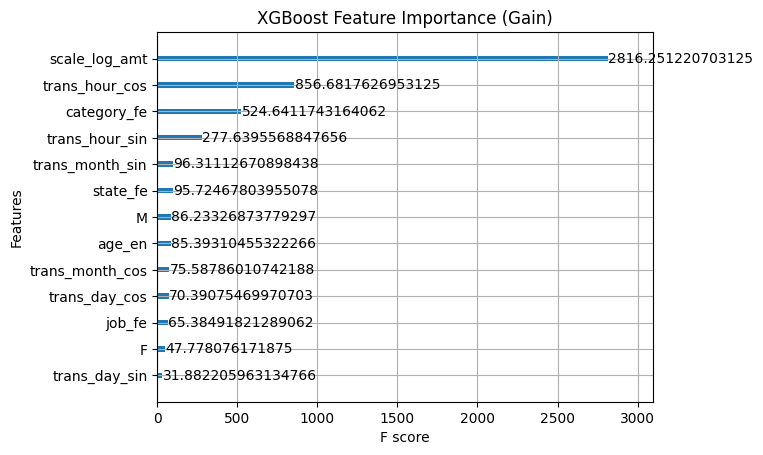

In [53]:
xgboost.plot_importance(xgb, importance_type='gain', title='XGBoost Feature Importance (Gain)')
plt.show()

Confusion Matric (XGBoost)

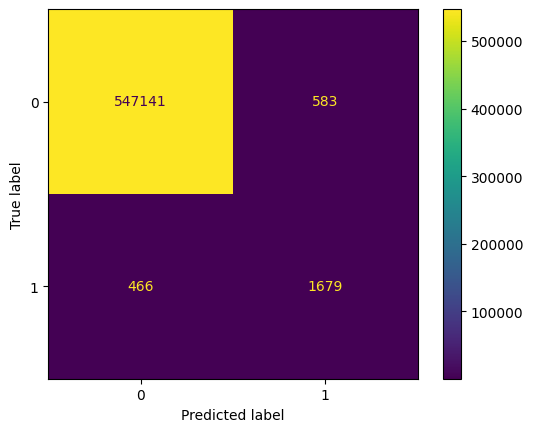

In [54]:
y_pred_test = xgb.predict(X_test)
xgb_pred_test = y_pred_test
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

roc-auc (XGBoost)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


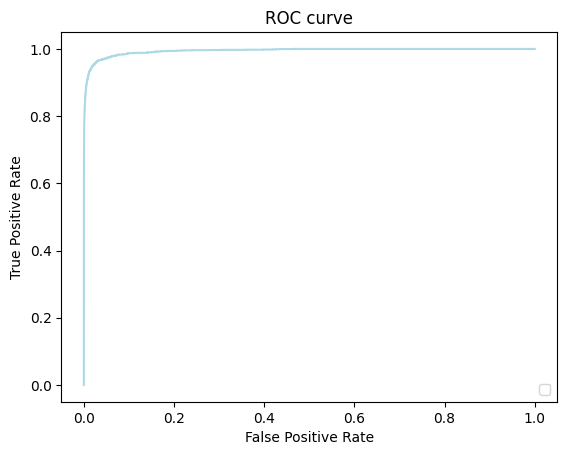

In [55]:
y_proba = xgb.predict_proba(X_test)
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'lightblue')
    plt.title('ROC curve')
plot_auc_roc_curve(y_test, y_proba[:,1])

# ***Light Gradient Boosting Model (LightGBM)***

---






Optuna Hyperparameter Tuning

In [56]:
import pandas as pd
import numpy as np
from optuna import create_study
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, recall_score, precision_score, accuracy_score
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score, log_loss,roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import lightgbm as lgb

test = pd.read_csv('TEST')
train = pd.read_csv('TRAINING')
validation = pd.read_csv('VALIDATION')

X_train_ = train.drop(["is_fraud"], axis = 1)
X_test = test.drop(["is_fraud"], axis = 1)
Xval = validation.drop(["is_fraud"], axis = 1)
y_train_ = train["is_fraud"]
y_test = test["is_fraud"]
yval = validation["is_fraud"]

def instantiate_lgb(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "n_estimators": 1000,
        "verbosity": -1,
        'verbose': 0,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.03,1, log=True),
        "num_leaves": trial.suggest_int("num_leaves",150,250),
        "subsample": trial.suggest_float("subsample", 0.1, 0.5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 800, 1000),
        "num_iterations": trial.suggest_int('num_iterations',150, 200),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.5, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "random_state": 88
    }
    return lgb.LGBMClassifier(**params)
def objective(trial, X, y, X_val, y_val):
    model = instantiate_lgb(trial)
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "binary_logloss")
    model.fit(
        X,
        y,
        eval_set=[(X_val, y_val)],
        callbacks=[pruning_callback])
    preds = model.predict(X_val)
    log = log_loss(y_val, preds)
    return log
#study = create_study(direction = 'minimize',
#pruner=SuccessiveHalvingPruner(reduction_factor=2),
#sampler=RandomSampler(seed=88))
#study.optimize(lambda trial : objective(trial, X_train_, y_train_, Xval, yval), n_trials = 10)
#best_param = study.best_params
best_param =  {
        "objective": "binary",
        "metric": "binary_logloss",
        "n_estimators": 1000,
        "verbosity": -1,
        'verbose': 0,
        "bagging_freq": 1,
        "learning_rate": 0.05473594500992221,
        "num_leaves": 216,
        "subsample": 0.4501593377601193,
        "colsample_bytree":  0.590744935294973,
        "min_data_in_leaf": 979,
        "num_iterations": 160,
        "reg_alpha": 0.9391848315915395,
        "reg_lambda":  6.111435510532287,
        "random_state": 88
    }
lg = lgb.LGBMClassifier(**best_param)


# Feature Importance Tuning
def val_model_get_importance(X_val_, y_val_):
    lg.fit(X_val_, y_val_)
    return lg.feature_importances_

current_features = Xval.columns.tolist()
performance_history = []
remove_features = []

for i in range(len(current_features)):
    importances = val_model_get_importance(Xval[current_features], yval)
    val_performance = f1_score(yval, lg.predict(Xval[current_features]))
    performance_history.append(val_performance)

    # Get the least important feature
    least_important = current_features[np.argmin(importances)]
    remove_features.append(least_important)
    current_features.remove(least_important)

    if val_performance < 0.5:
        break

features_to_remove = remove_features[:np.argmax(performance_history)]

X_train = pd.concat([X_train_, Xval]).drop(features_to_remove, axis = 1)
y_train = pd.concat([y_train_, yval])

X_test = X_test.drop(features_to_remove, axis = 1)

lg.fit(X_train, y_train)

#tree_index = 0
#fig, ax = plt.subplots(figsize=(20, 20))
#lgb.plot_tree(lg, tree_index=tree_index, ax=ax, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
#plt.savefig('tree_visualization.png')


c:\Users\regan\Documents\NUS\NUS Modules\Year 3 Semester 1\BT4012\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\regan\Documents\NUS\NUS Modules\Year 3 Semester 1\BT4012\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\regan\Documents\NUS\NUS Modules\Year 3 Semester 1\BT4012\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\regan\Documents\NUS\NUS Modules\Year 3 Semester 1\BT4012\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of arg

LGBMClassifier(bagging_freq=1, colsample_bytree=0.590744935294973,
               learning_rate=0.05473594500992221, metric='binary_logloss',
               min_data_in_leaf=979, n_estimators=1000, num_iterations=160,
               num_leaves=216, objective='binary', random_state=88,
               reg_alpha=0.9391848315915395, reg_lambda=6.111435510532287,
               subsample=0.4501593377601193, verbose=0, verbosity=-1)

Evaluation (LightGBM)

In [57]:
# Train Metrics

lgb_train_metrics = get_metrics_pd(lg.predict(X_train), y_train, "LightGBM [Train]")

# Test Metrics
lgb_pre_test = lg.predict(X_test)
lgb_test_metrics = get_metrics_pd(lgb_pre_test, y_test, "LightGBM [Test]")
output_df = pd.concat([lgb_train_metrics, lgb_test_metrics], axis = 0)
output_df

,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,LightGBM [Train],0.998014,0.998495,0.998254,0.998688,0.998554
0,LightGBM [Test],0.751049,0.775265,0.762965,0.998180,0.875098


Feautre Importance (LightGBM)

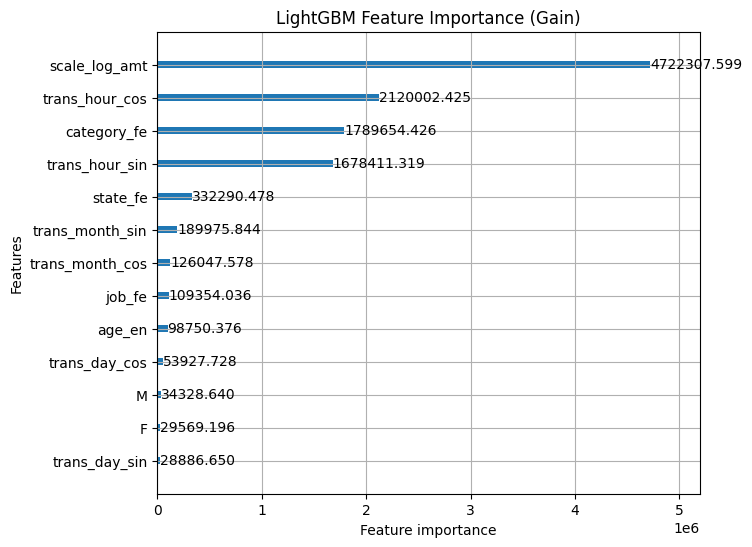

In [58]:
lgb.plot_importance(lg, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

Confusion Matrix (LightGBM)

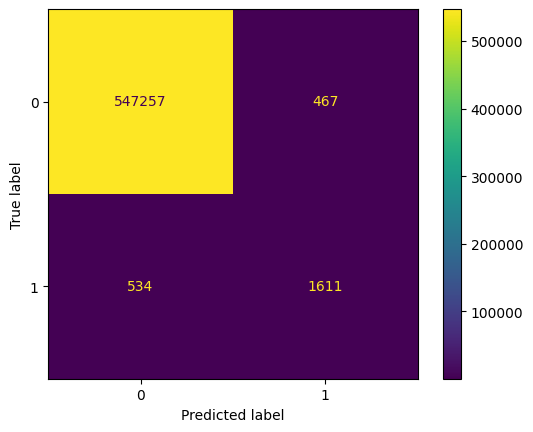

In [59]:
cm = confusion_matrix(y_test, lg.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

roc-auc (LightGBM)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


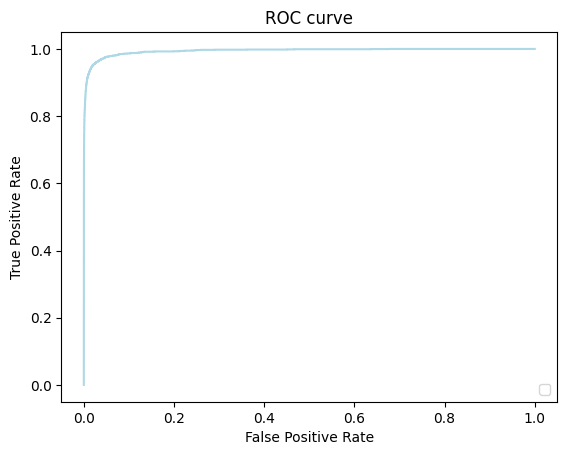

In [60]:
y_proba = lg.predict_proba(X_test)
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'lightblue')
    #plt.plot([0, 1], [0, 1], color = 'lightblue')
    plt.title('ROC curve')
plot_auc_roc_curve(y_test, y_proba[:,1])

# Credit Card Predictions (Threshold = 1)

Obtaining Fraudulent Credit Card (XGBoost)

In [63]:
credit_card_test = pd.read_csv("TEST_FULL")[["cc_num", "is_fraud"]]
test = pd.read_csv('TEST')

X_test = test.drop(columns= 'is_fraud')
y_test = test['is_fraud']

y_pred_test = xgb.predict(X_test)

credit_card_test['is_fraud_pr'] = y_pred_test
credit_card = {}
for _, row in credit_card_test.iterrows():
    real = row['is_fraud']
    not_real = row['is_fraud_pr']
    cc_num = row['cc_num']
    val = credit_card.get(cc_num, [0,0])
    real1 = val[0] + real
    not_real1 = val[1] + not_real
    credit_card[cc_num] = [real1, not_real1]

num_fraud = 0
num_predict_right = 0
num_predict_wrong = 0
num_predict_wrong_miss = 0
threshold = 1
total = 0
for i in credit_card.items():
    l = i[1]
    if l[0]>0:
        num_fraud += 1
        if l[1] > threshold:
            num_predict_right += 1
        else:
            num_predict_wrong_miss += 1
    else:
        if l[1] > threshold:
            num_predict_wrong += 1
    total += 1

out = pd.DataFrame([(total, num_predict_right, num_predict_wrong_miss, num_predict_wrong)], columns = ['Total Number of Credit Cards',
                                                                                                       'No of Fraudulent Credit Cards Predicted Fraudulent',
                                                                                                       'No of Fraudulent Credit Cards Predicted Non-Fraudulent',
                                                                                                       'No of Non-Fraudulent Credit Cards Predicted Fraudulent'])
out

,Total Number of Credit Cards,No of Fraudulent Credit Cards Predicted Fraudulent,No of Fraudulent Credit Cards Predicted Non-Fraudulent,No of Non-Fraudulent Credit Cards Predicted Fraudulent
0,918,216,2,116


# Graph Features

## Data Preparation

In [64]:
# Make sure it is the preprocessed not resampled data

train_final = pd.read_csv("TRAIN_FINAL")
test_final = pd.read_csv("TEST_FINAL")

X_train = train_final.drop(["is_fraud"], axis = 1)
X_test = test_final.drop(["is_fraud"], axis = 1)
y_train = train_final["is_fraud"]
y_test = test_final["is_fraud"]

from sklearn.cluster import MiniBatchKMeans

cc = ClusterCentroids(sampling_strategy = 1.0, estimator=MiniBatchKMeans(n_init=10, random_state=88), random_state = 88)

X_train_res, y_train_res = cc.fit_resample(X_train, y_train)
X_train_res = pd.concat([X_train_res, y_train_res], axis = 1)
X_train_res.value_counts("is_fraud")

is_fraud
0    7446
1    7446
Name: count, dtype: int64

## Graph Generation

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# Construction of adjacency matrix
X_train_network = X_train_res[['state_fe', 'category_fe', 'job_fe', 'M', 'F', 'age_en', 'scale_log_amt', "trans_day_sin", "trans_day_cos", "trans_hour_sin",
                               "trans_hour_cos", "trans_month_sin", "trans_month_cos"]]

cos_sparse = sparse.csr_matrix(X_train_network)
cos_sims = cosine_similarity(cos_sparse)

# Any value that has a cosine similarity that is less than 0.5 will be set to 0, aka no linkage
cos_sims[cos_sims < 0.5] = 0

# Fill diagonals with 0
np.fill_diagonal(cos_sims, 0)

In [69]:
import igraph as ig
G = ig.Graph.Weighted_Adjacency(cos_sims, mode = "undirected")

edge_weights = G.es["weight"]

# Degree Centrality
dc = G.degree()
n = len(G.vs)
dc_norm = [d / (n - 1) for d in dc]

# PageRank Metrics
pers_df = y_train_res
reset_i = pers_df.index[pers_df == 1]

edge_weights = G.es["weight"]
pr = G.personalized_pagerank(directed = False, weights = edge_weights)

degree_centrality = pd.DataFrame(dc_norm, columns=['degree_centrality'])
pagerank_pd = pd.DataFrame(pr, columns = ["pagerank"])

G_info = pd.concat([degree_centrality, pagerank_pd], axis=1)

train_cc_network = pd.concat([X_train_res, G_info], axis = 1)

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

train_cc_network_sub = train_cc_network[['degree_centrality','pagerank']]
train_cc_network_sub_scaled = pd.DataFrame(scalar.fit_transform(train_cc_network_sub))
train_cc_network_sub_scaled.columns = ['scaled_degree_centrality','scaled_pagerank']
train_cc_network_scaled = pd.concat([train_cc_network, train_cc_network_sub_scaled], axis=1)

train_cc_network_scaled.head()

,trans_day_sin,trans_day_cos,trans_hour_sin,trans_hour_cos,trans_month_sin,trans_month_cos,state_fe,category_fe,job_fe,M,F,age_en,scale_log_amt,is_fraud,degree_centrality,pagerank,scaled_degree_centrality,scaled_pagerank
0,0.000000,1.000000,-1.000000,-1.836970e-16,1.000000e+00,6.123234e-17,0.033259,0.095476,0.001174,1.0,0.0,0.0,0.102434,0,0.072326,0.000027,-1.451568,-1.697802
1,0.781831,0.623490,-0.707107,7.071068e-01,1.224647e-16,-1.000000e+00,0.011259,0.092740,0.003818,0.0,1.0,1.0,-0.055005,0,0.193875,0.000054,-0.621548,-0.539785
2,0.000000,1.000000,0.500000,-8.660254e-01,8.660254e-01,-5.000000e-01,0.015954,0.095950,0.002779,1.0,0.0,1.0,0.460540,0,0.160701,0.000045,-0.848084,-0.945807
3,-0.974928,-0.222521,-0.866025,5.000000e-01,5.000000e-01,8.660254e-01,0.020855,0.069947,0.002378,0.0,1.0,1.0,0.670522,0,0.325297,0.000071,0.275882,0.147174
4,-0.433884,-0.900969,-0.707107,7.071068e-01,5.000000e-01,-8.660254e-01,0.014750,0.090004,0.004815,0.0,1.0,1.0,-2.325833,0,0.166946,0.000062,-0.805437,-0.234944


In [ ]:
test_network = test_final[['state_fe', 'category_fe', 'job_fe', 'M', 'F', 'age_en', 'scale_log_amt', "trans_day_sin", "trans_day_cos", "trans_hour_sin",
                               "trans_hour_cos", "trans_month_sin", "trans_month_cos"]]

def normalize_rows(mat):
    return mat / np.linalg.norm(mat, axis=1, keepdims=True)

# Normalize data
normalized_train = normalize_rows(X_train_network)
normalized_test = normalize_rows(test_network)

# Function to process a batch of test data
def process_batch(test_batch, train_data):
    cosine_similarities = np.dot(test_batch, train_data.T)
    max_similarity_indices = np.argmax(cosine_similarities, axis=1)
    max_similarities = np.max(cosine_similarities, axis=1)
    return max_similarity_indices, max_similarities

# Define batch size
batch_size = 1000  # Adjust this based on your memory capacity

# Initialize lists to store results
all_max_indices = []
all_max_similarities = []

# Process in batches
for i in range(0, normalized_test.shape[0], batch_size):
    test_batch = normalized_test[i:i + batch_size]
    max_indices, max_sims = process_batch(test_batch, normalized_train)
    all_max_indices.extend(max_indices)
    all_max_similarities.extend(max_sims)

# Assuming all_max_indices is already calculated
train_degree_centrality = train_cc_network_scaled['scaled_degree_centrality'].values
train_pagerank = train_cc_network_scaled['scaled_pagerank'].values

matched_degree_centrality = train_degree_centrality[all_max_indices]
matched_pagerank = train_pagerank[all_max_indices]

# Create a copy of the test DataFrame and add new columns
test_final_matched = test_final.copy()
test_final_matched['scaled_degree_centrality'] = matched_degree_centrality
test_final_matched['scaled_pagerank'] = matched_pagerank

## Graph Results

### On Undersampled Data

c:\Users\regan\Documents\NUS\NUS Modules\Year 3 Semester 1\BT4012\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_data_in_leaf", "num_iterations", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


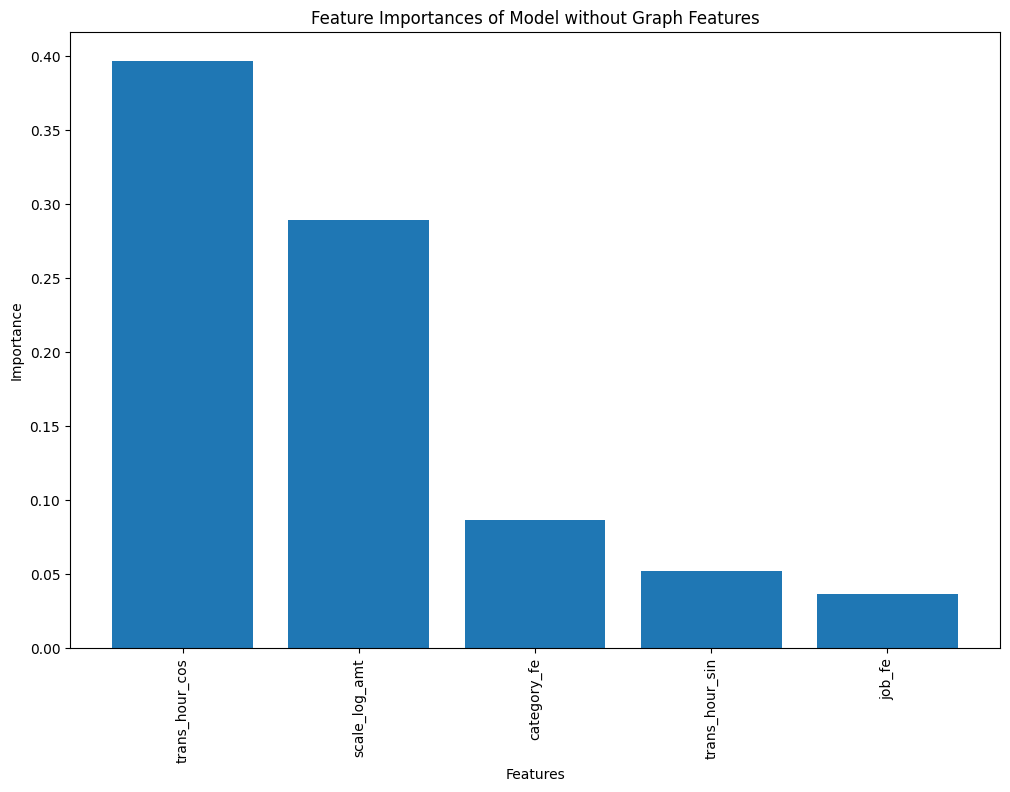

In [ ]:
X_train_undersamp = X_train_res.drop(columns = "is_fraud")
y_train_undersamp = X_train_res["is_fraud"]

X_test_final = test_final.drop(columns = "is_fraud")
y_test_final = test_final["is_fraud"]

xgb.fit(X_train_undersamp, y_train_undersamp)

xgb_undersamp = get_metrics_pd(xgb.predict(X_test_final), y_test_final, "XGBoost W/O Graph Features [Test]")

feature_importances_graph = xgb.feature_importances_
feature_names_graph = X_train_undersamp.columns

import matplotlib.pyplot as plt

# Create a DataFrame for easy sorting
importances_df = pd.DataFrame({
    'Feature': feature_names_graph,
    'Importance': feature_importances_graph
})
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation='vertical')
plt.title('Feature Importances of Model without Graph Features')
plt.show()

### On Graph Feature Data

c:\Users\regan\Documents\NUS\NUS Modules\Year 3 Semester 1\BT4012\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_data_in_leaf", "num_iterations", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


['trans_day_sin', 'trans_day_cos', 'trans_hour_sin', 'trans_hour_cos', 'trans_month_sin', 'trans_month_cos', 'state_fe', 'category_fe', 'job_fe', 'M', 'F', 'age_en', 'scale_log_amt', 'scaled_degree_centrality', 'scaled_pagerank']
[0.01135005 0.01059288 0.0544081  0.27191058 0.01504138 0.01011803
 0.01308297 0.05600384 0.02659437 0.01005666 0.02727655 0.04559306
 0.19073407 0.23833218 0.01890537]


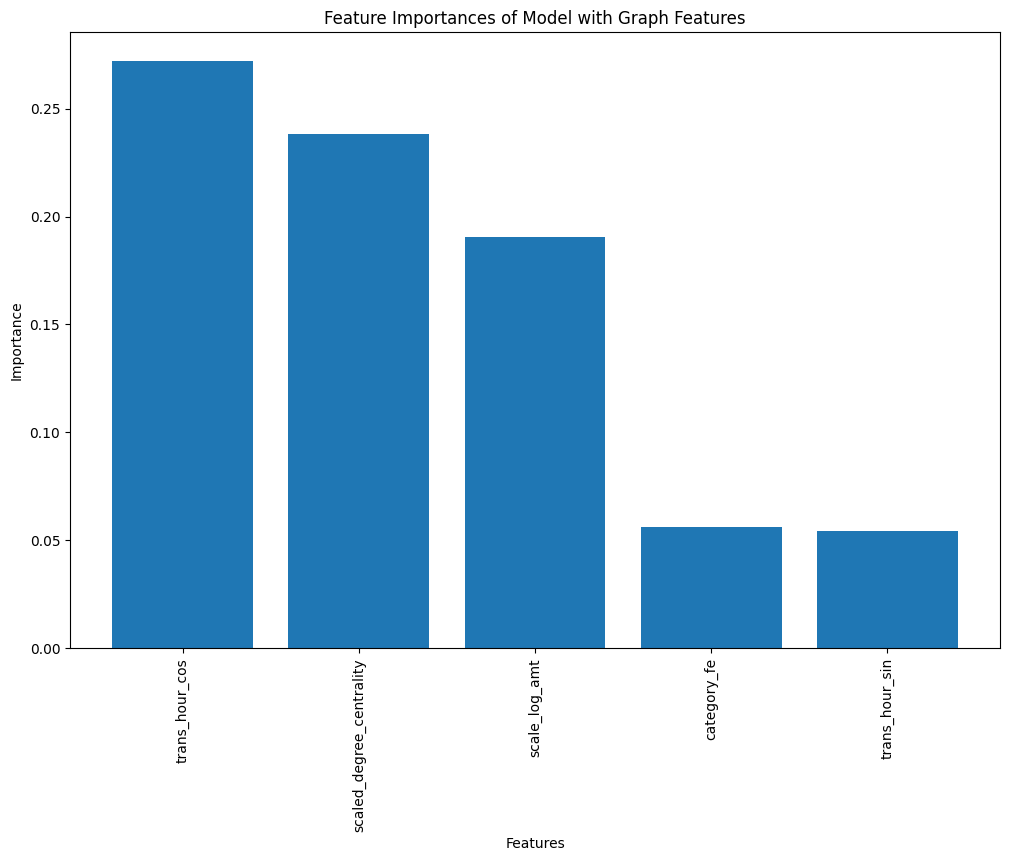

In [ ]:
X_train_graph = train_cc_network_scaled.drop(columns = "is_fraud").drop(columns = ['degree_centrality', 'pagerank'])
y_train_graph = train_cc_network_scaled["is_fraud"]

X_test_graph = test_final_matched.drop(columns = "is_fraud")
y_test_graph = test_final_matched["is_fraud"]

xgb.fit(X_train_graph, y_train_graph)

print(X_train_graph.columns.tolist())
print(xgb.feature_importances_)

xgb_graph = get_metrics_pd(xgb.predict(X_test_graph), y_test_graph, "XGBoost W Graph Features [Test]")

feature_importances_graph = xgb.feature_importances_
feature_names_graph = X_train_graph.columns

import matplotlib.pyplot as plt

# Create a DataFrame for easy sorting
importances_df = pd.DataFrame({
    'Feature': feature_names_graph,
    'Importance': feature_importances_graph
})
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation='vertical')
plt.title('Feature Importances of Model with Graph Features')
plt.show()

In [ ]:
graph_feature_perf = pd.concat([xgb_undersamp, xgb_graph], axis = 0)
graph_feature_perf

,Model,Recall,Precision,F1 Score,Accuracy,AUC
0,XGBoost W/O Graph Features [Test],0.967366,0.126865,0.224312,0.973901,0.970646
0,XGBoost W Graph Features [Test],0.969231,0.122352,0.217275,0.972759,0.971002
